In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import pandas as pd
import os
import re
from PIL import Image
import shutil
import xml.etree.ElementTree as et
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
                        
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns

print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


In [3]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
# True

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [10]:
data_dir = '/Users/ksjljk1030/drug_image3/'
image_dir = os.path.join(data_dir, 'real_image2')
print(image_dir)
bbox_dir = os.path.join(data_dir, 'annotation2')
print(bbox_dir)
#aug_data = = os.path.join(data_dir, 'imgaug')
#print(aug_data)

/Users/ksjljk1030/drug_image3/real_image2
/Users/ksjljk1030/drug_image3/annotation2


In [11]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))
image_files[:5]

30000


['가나릴정.jpg',
 '가나릴정.jpg_1.jpg',
 '가나릴정.jpg_2.jpg',
 '가나릴정.jpg_3.jpg',
 '가나릴정.jpg_4.jpg']

In [12]:
class_list = set()
for image_file in image_files:
    file_name = re.split('[/,(,). :, _]',image_file)[-2]
    class_name = re.split('[/,(,). :, _]',image_file)[-2]
    if class_name =='1' or class_name =='2' or class_name =='3' or class_name =='4' or class_name =='5' or class_name =='6' or class_name =='7' or class_name =='8' or class_name =='9':
        continue
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))
#print(class_list)

3000


In [13]:
class_list.sort()
class_list[:5]

['가나릴정', '가나메드정', '가나칸정50밀리그램', '가나텍정', '가나톤정50밀리그램']

In [14]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx['가나릴정']

0

In [15]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
#os.makedirs(train_dir, exist_ok=True)
#os.makedirs(val_dir, exist_ok=True)

In [69]:
#한번했으면 실행x
cnt = {}
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    #print(file_name)
    class_name = re.split('[/,(,). :, _]',file_name)[0]
    #print(class_name)
    if class_name in cnt:
        cnt[class_name] += 1
    else:
        cnt[class_name] = 1
    if cnt[class_name] <= 8:
        cpath = train_dir
    else:
        cpath = val_dir
    image_path = os.path.join(image_dir, image_file)
    shutil.copy(image_path, cpath)

In [17]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

In [18]:
print(len(train_images), len(val_images))

24000 6000


In [16]:
IMG_SIZE = 224

In [22]:
tfr_dir = os.path.join(data_dir, 'tfrecord')
#os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [23]:
#한번했으면 실행x
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [24]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [25]:
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files:
    train_path = os.path.join(train_dir, train_file)
    image = Image.open(train_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()
    
    file_name = os.path.splitext(train_file)[0] #Bangal_101
    class_name = re.split('[/,(,). :, _]',file_name)[0]
    #print(class_name)
    class_num = class2idx[class_name]

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num)
    }))
    writer_train.write(example.SerializeToString())
    n_train += 1

writer_train.close()
print(n_train)

24000


In [26]:
n_val = 0

val_files = os.listdir(val_dir)
for val_file in val_files:
    val_path = os.path.join(val_dir, val_file)
    image = Image.open(val_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()

    file_name = os.path.splitext(val_file)[0] #Bangal_101
    class_name = re.split('[/,(,). :, _]',file_name)[0]
    class_num = class2idx[class_name]

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num)
    }))
    writer_val.write(example.SerializeToString())
    n_val += 1

writer_val.close()
print(n_val)

6000


In [39]:
N_CLASS = len(class_list)
N_EPOCHS = 30
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [40]:
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    label = tf.one_hot(label, N_CLASS)

    return image, label

In [41]:
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [42]:
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

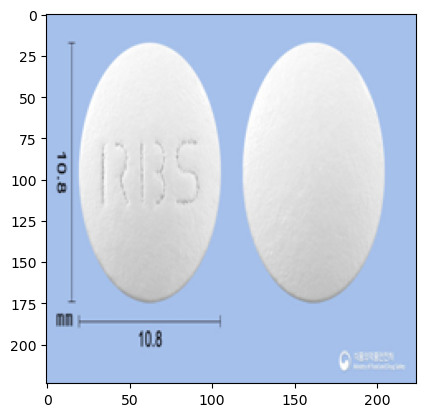

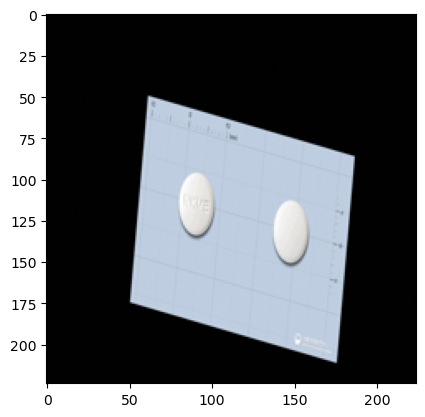

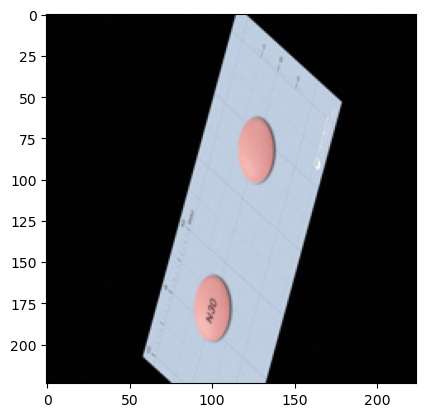

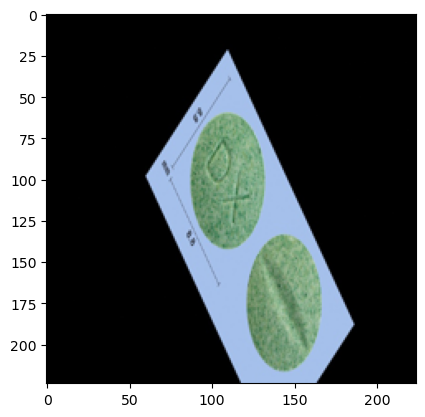

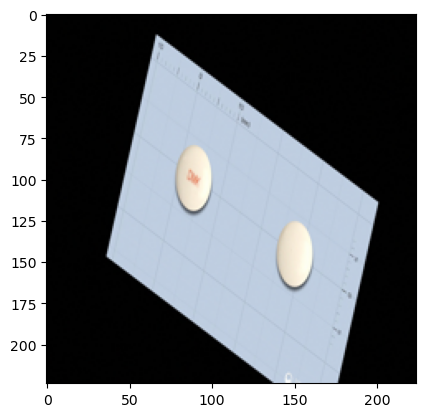

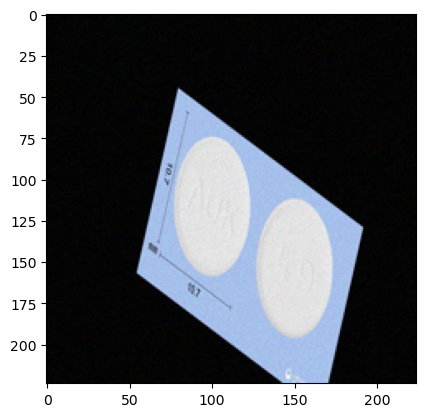

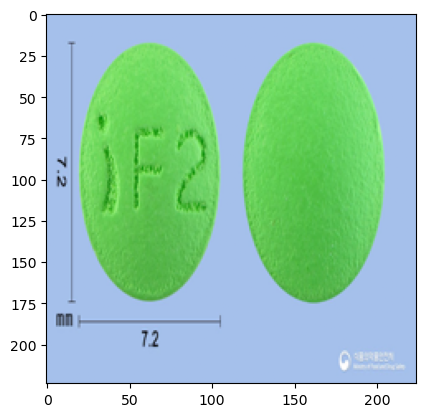

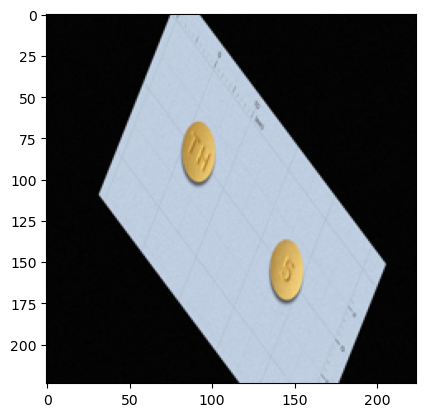

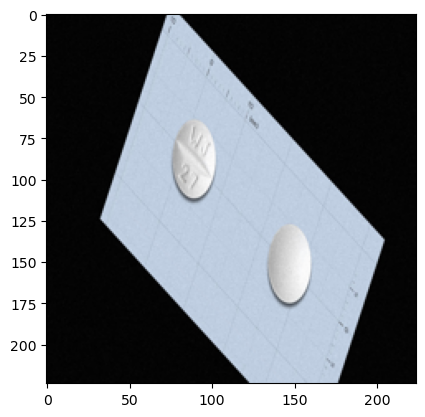

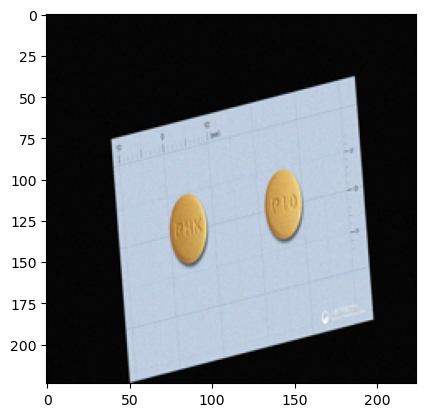

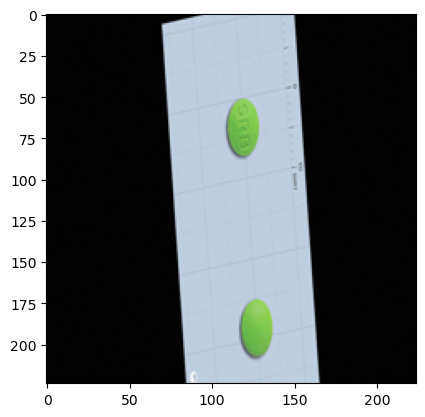

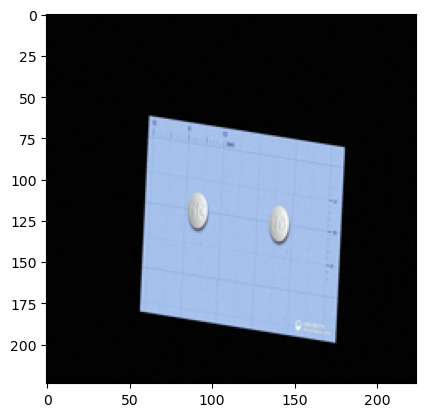

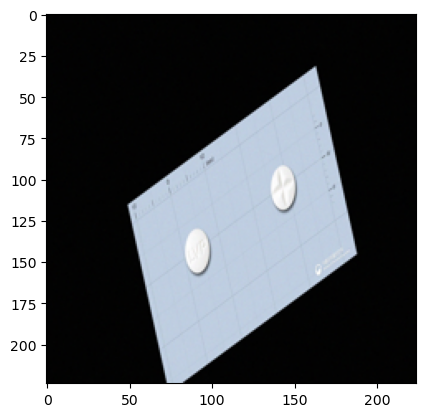

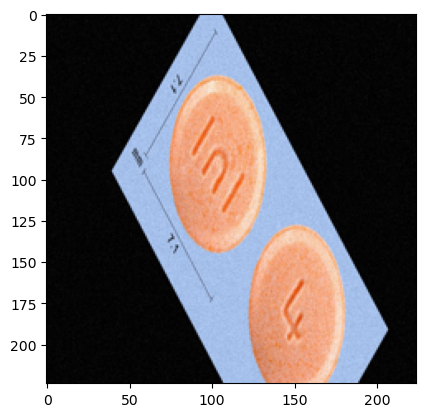

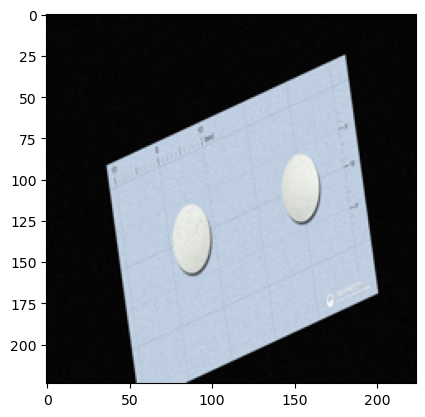

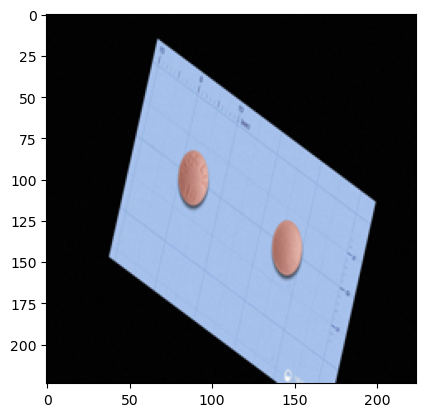

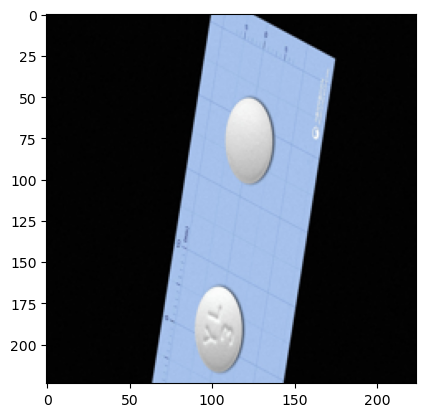

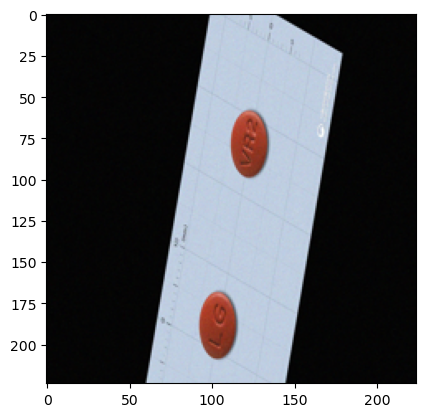

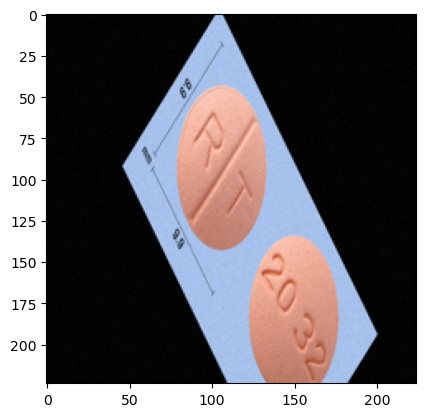

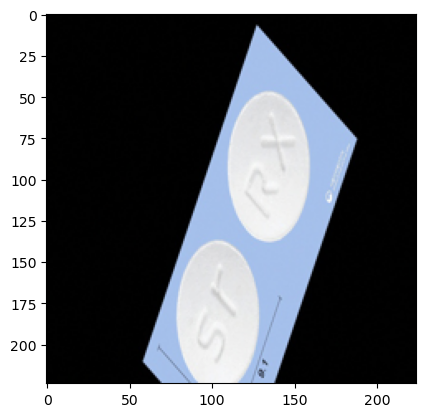

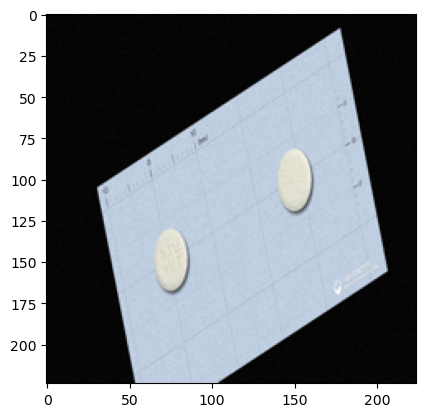

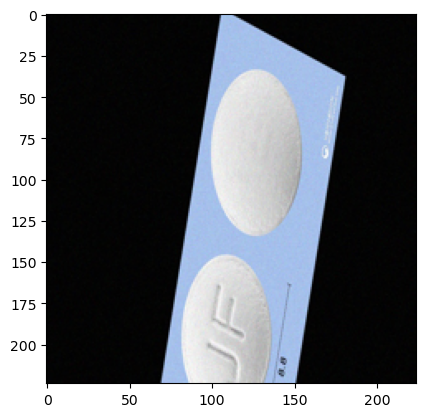

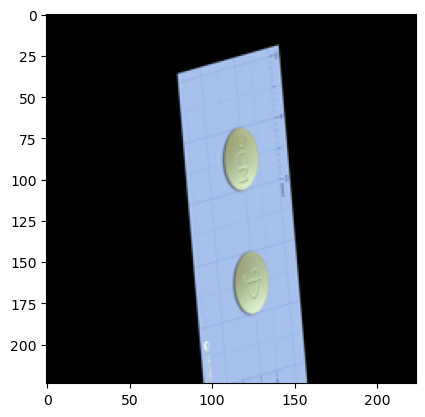

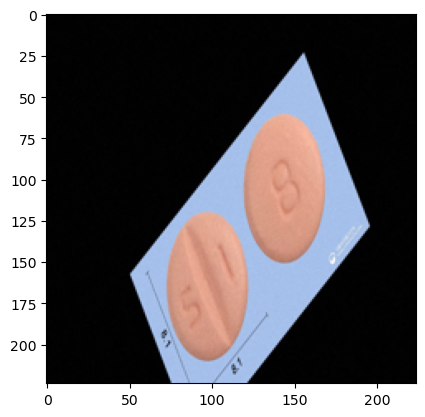

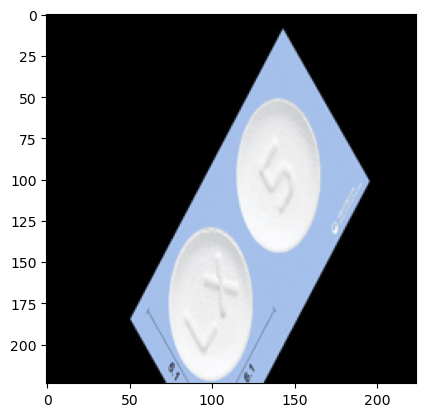

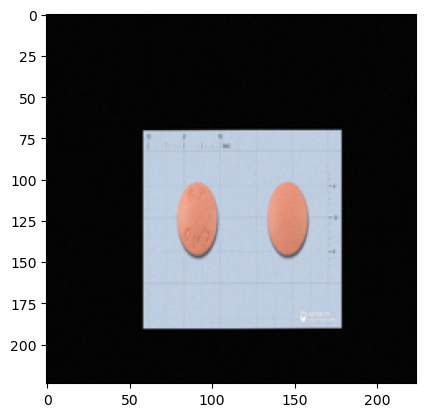

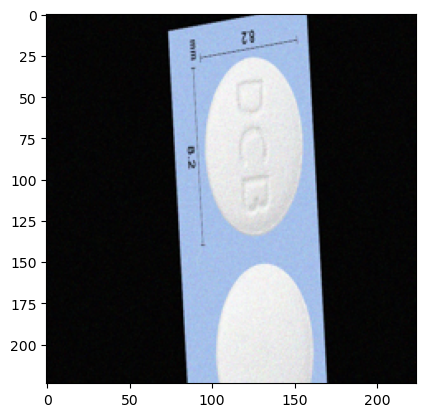

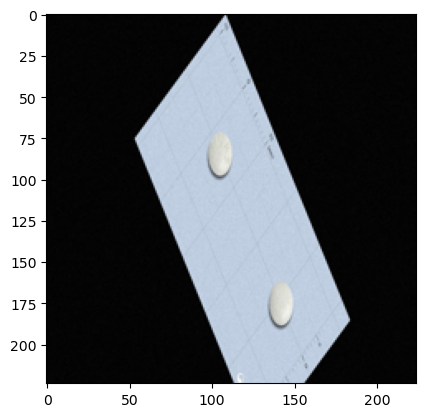

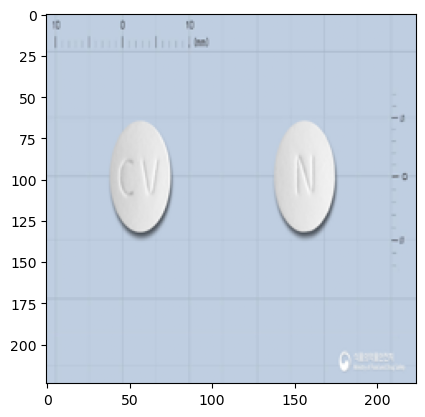

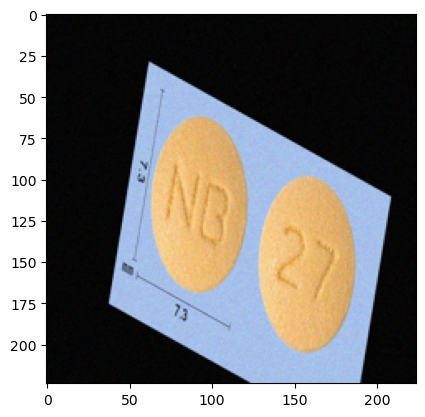

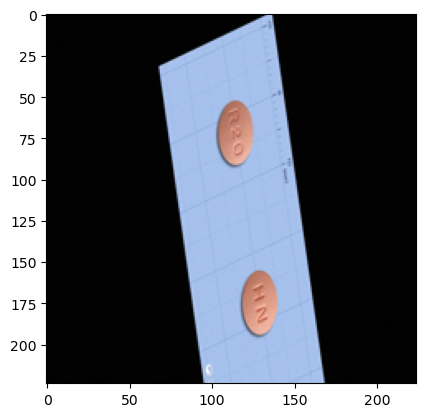

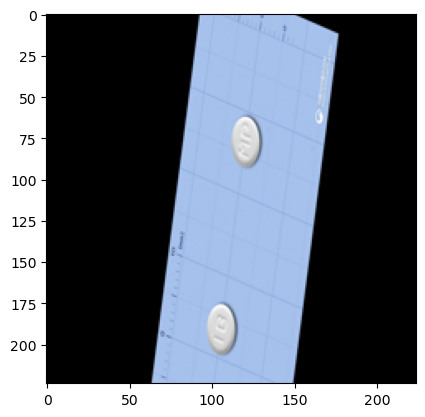

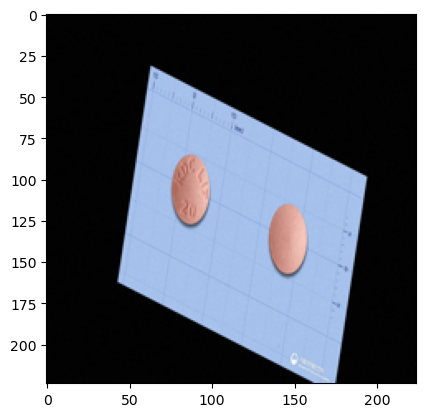

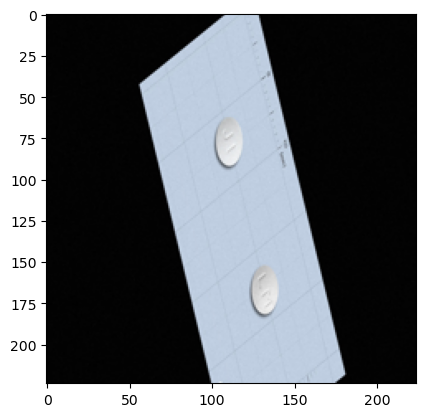

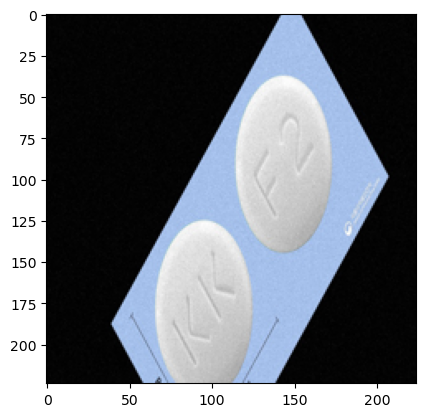

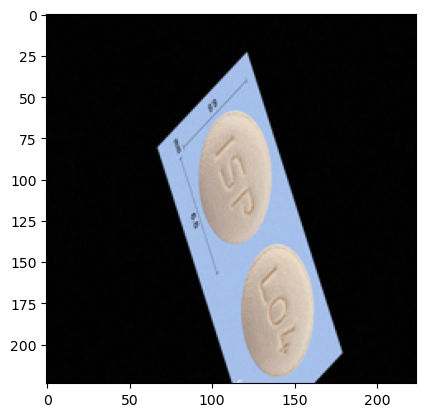

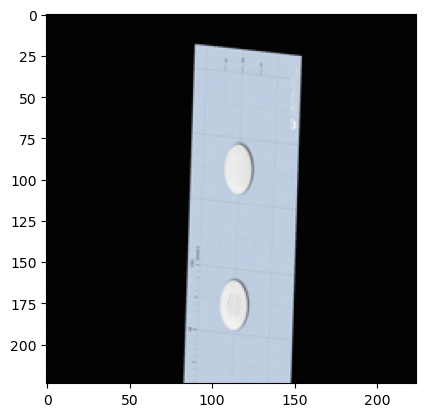

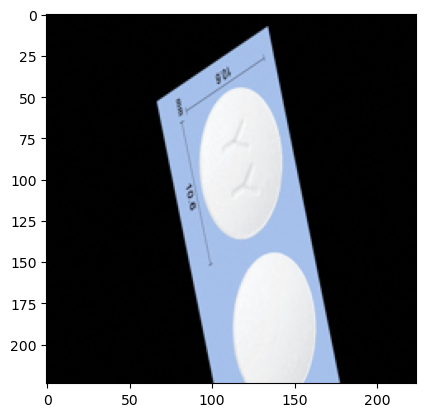

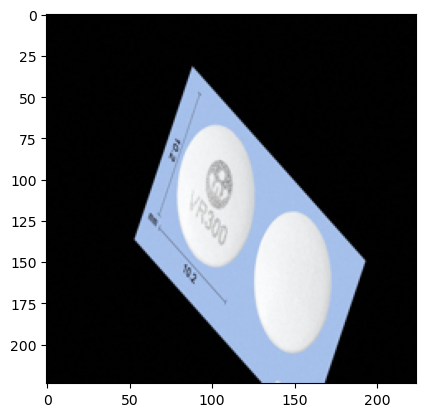

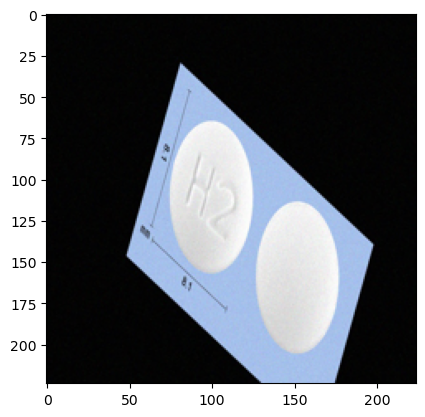

In [43]:
for image, label in train_dataset.take(1):
  for i in range(N_BATCH):    
#     print(label[i].numpy())
    plt.imshow(image[i])
    plt.show()

In [44]:
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [45]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [46]:
def create_mv_model():
    last = mobilenetv2.output
    x = GlobalAveragePooling2D()(last)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    pred = Dense(N_CLASS, activation='softmax')(x)
    
    model = Model(mobilenetv2.input, pred)
    model.summary
    return model

In [47]:
model = create_mv_model()

LR_INIT = 0.000001
LR_MAX = 0.0002
LR_MIN = LR_INIT
RAMPUP_EPOCH = 4
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
    if epoch < RAMPUP_EPOCH:
        lr = (LR_MAX - LR_MIN) / RAMPUP_EPOCH * epoch + LR_INIT
    else:
        lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMPUP_EPOCH)
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

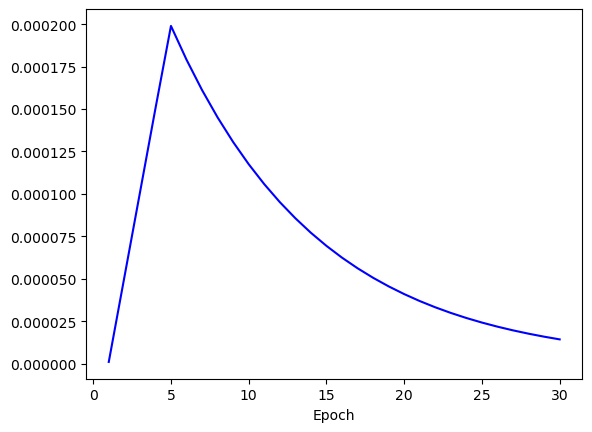

In [48]:
def plot_lr():
  lr = []
  epoch_list = list(np.arange(N_EPOCHS) + 1)
  for epoch in range(N_EPOCHS):
    lr.append(lr_schedule_fn(epoch))    
  plt.plot(epoch_list, lr, 'b-')
  plt.xlabel('Epoch')
  plt.show()

plot_lr()

In [49]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[lr_callback]
)

Epoch 1/30
600/600 [==============================] - 127s 193ms/step - loss: 8.0449 - accuracy: 3.7500e-04 - val_loss: 8.0546 - val_accuracy: 0.0000e+00 - lr: 1.0000e-06
Epoch 2/30
600/600 [==============================] - 128s 194ms/step - loss: 7.9167 - accuracy: 0.0022 - val_loss: 7.8009 - val_accuracy: 0.0032 - lr: 5.0750e-05
Epoch 3/30
600/600 [==============================] - 150s 228ms/step - loss: 7.3871 - accuracy: 0.0240 - val_loss: 7.1181 - val_accuracy: 0.0368 - lr: 1.0050e-04
Epoch 4/30
600/600 [==============================] - 150s 226ms/step - loss: 6.4338 - accuracy: 0.1040 - val_loss: 5.8490 - val_accuracy: 0.1663 - lr: 1.5025e-04
Epoch 5/30
600/600 [==============================] - 153s 227ms/step - loss: 5.0563 - accuracy: 0.2875 - val_loss: 4.4984 - val_accuracy: 0.2832 - lr: 1.9900e-04
Epoch 6/30
600/600 [==============================] - 150s 223ms/step - loss: 3.5679 - accuracy: 0.5936 - val_loss: 3.4735 - val_accuracy: 0.4530 - lr: 1.7910e-04
Epoch 7/30
600

In [92]:
model.save('Pill_image_pretrained_mobile_model_2.h5')

C:\Users\ksjljk1030\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


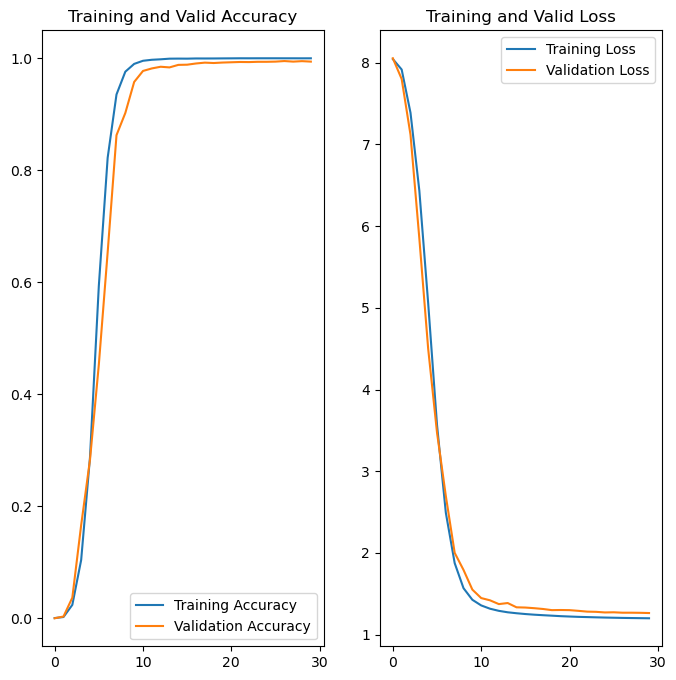

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(N_EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Valid Loss')
plt.show()

In [51]:
def test(img_dir):
    image = Image.open(img_dir)
    image = image.resize((224, 224))
    image = np.array(image)
    image = image/255.
    
    plt.imshow(image)
    plt.show()
    
    image = np.reshape(image, (1, 224, 224, 3))
    
    prediction = model.predict(image)
    prediction.shape
    pred_class = np.argmax(prediction, axis=-1)
    pred_class
    
    print("예측: ", class_list[int(pred_class)])

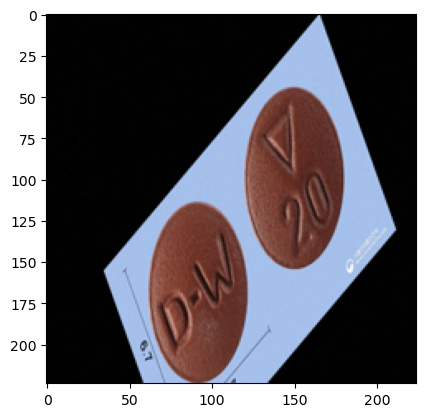

예측:  리바코르정20밀리그램


In [52]:
test('/Users/ksjljk1030/drug_image3/real_image2/리바코르정20밀리그램.jpg_4.jpg')

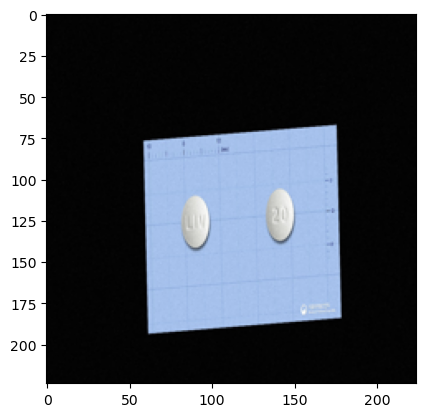

예측:  리반틴정20밀리그램


In [53]:
test('/Users/ksjljk1030/drug_image3/real_image2/리반틴정20밀리그램.jpg_4.jpg')

In [54]:
test_folder_dir = '/Users/ksjljk1030/drug_image3/validation/'
test_folders = os.listdir(test_folder_dir)

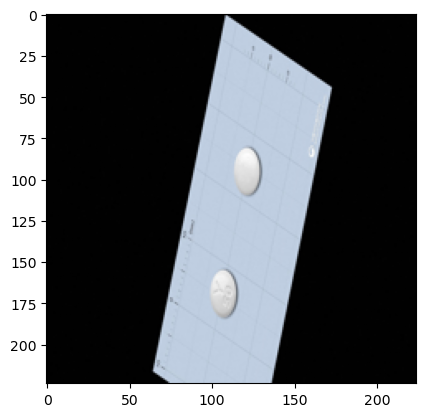

예측:  가나릴정
정답:  가나릴정


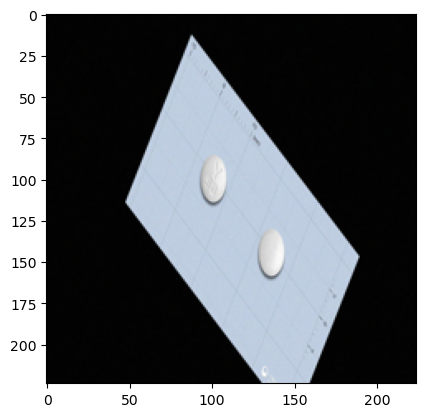

예측:  가나릴정
정답:  가나릴정


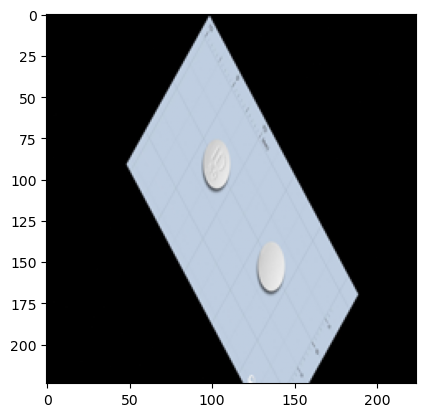

예측:  가나메드정
정답:  가나메드정


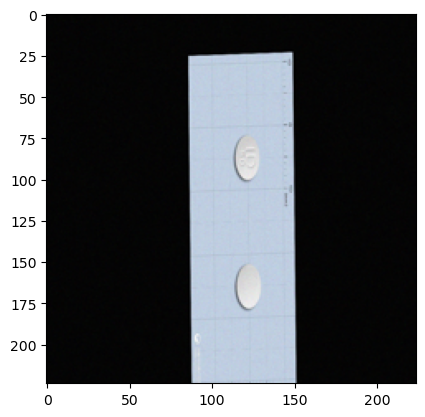

예측:  가나메드정
정답:  가나메드정


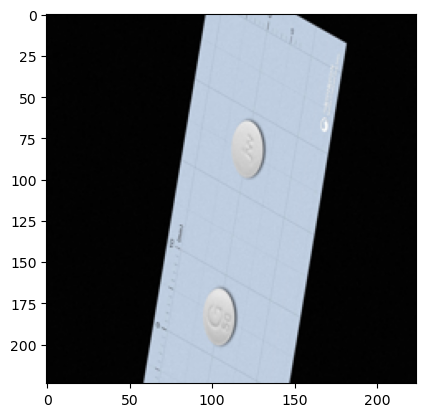

예측:  가나칸정50밀리그램
정답:  가나칸정50밀리그램


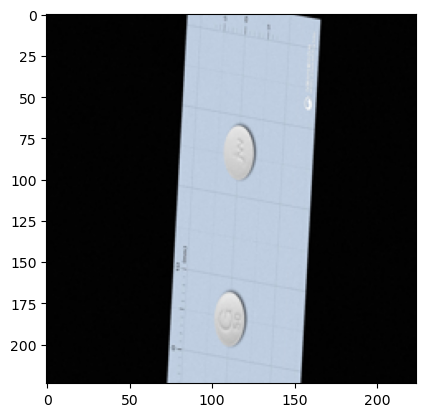

예측:  가나칸정50밀리그램
정답:  가나칸정50밀리그램


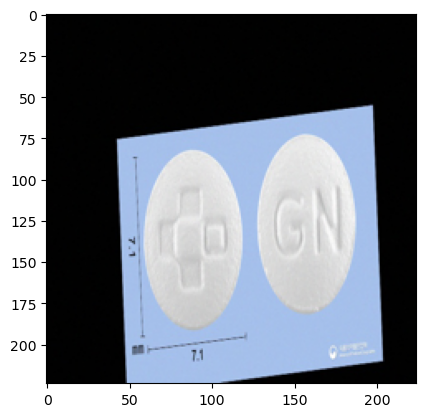

예측:  가나텍정
정답:  가나텍정


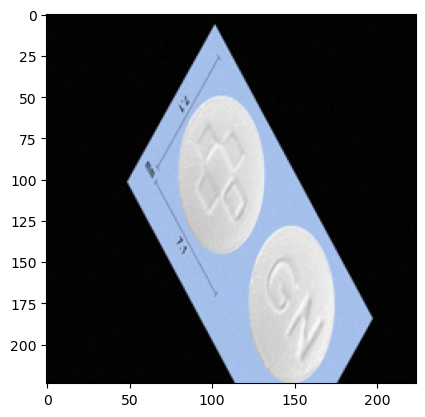

예측:  가나텍정
정답:  가나텍정


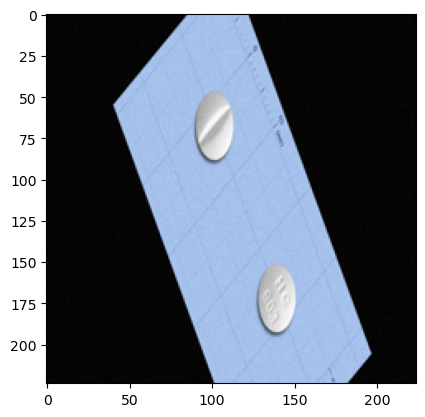

예측:  가나톤정50밀리그램
정답:  가나톤정50밀리그램


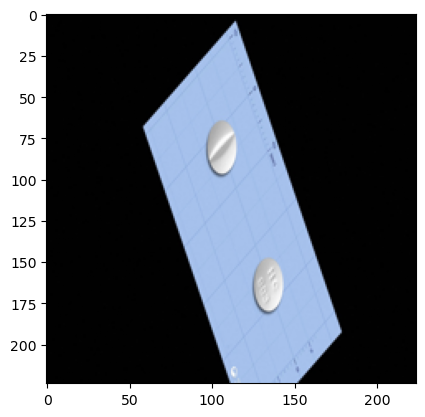

예측:  가나톤정50밀리그램
정답:  가나톤정50밀리그램


In [55]:
for i in range(10):
    test(os.path.join(test_folder_dir, test_folders[i]))
    print("정답: ", re.split('[/,(,). :, _]',test_folders[i])[0])

In [59]:
import tensorflow as tf
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

Predicted: 디멘페질정5밀리그램
정답:  디멘페질정5밀리그램


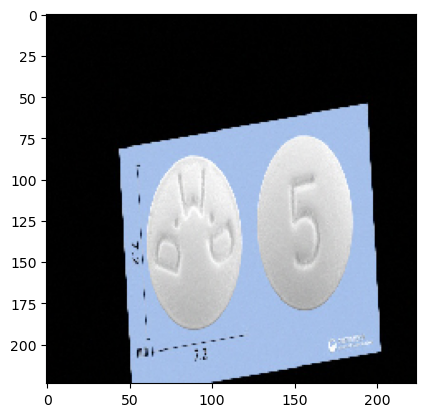

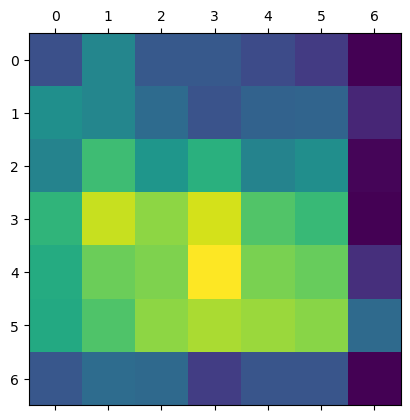

In [80]:
import random

inum = random.randrange(0,len(test_folders))
qimage0 = load_img(os.path.join(test_folder_dir, test_folders[inum]), target_size=(224, 224))
qimage  = img_to_array(qimage0)
qimage  = qimage.reshape((1, 224, 224, 3))
qimage  = preprocess_input(qimage)


# Print what the top predicted class is
preds = model.predict(qimage)
predicted_label = np.argmax(preds[0],axis=-1)
print("Predicted:", class_list[int(predicted_label)])
print("정답: ", re.split('[/,(,). :, _]',test_folders[inum])[0])


# Generate class activation heatmap
last_conv_layer_name = "Conv_1"
classifier_layer_names = [
    "global_average_pooling2d_1",
    "dense_2" 
    ]
heatmap = make_gradcam_heatmap(
    qimage, model, last_conv_layer_name, classifier_layer_names
    )

# Display heatmap
plt.imshow(qimage0)
plt.show()
plt.matshow(heatmap)
plt.show()

Predicted: 뉴마르딘정
정답:  나잘렌정


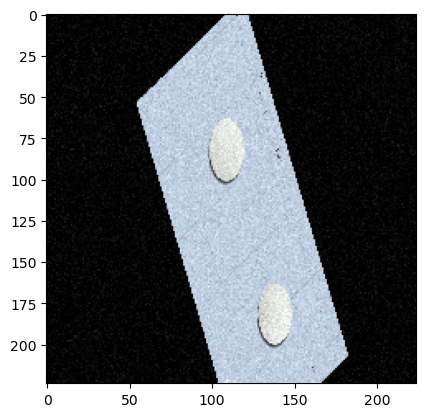

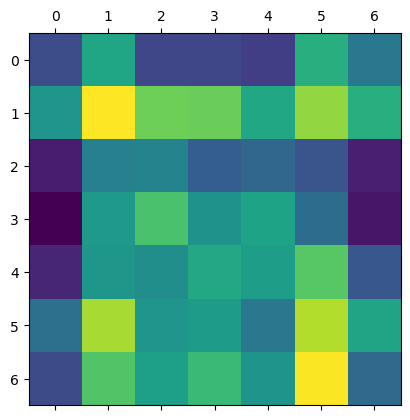

Predicted: 나제론오디정0
정답:  레바미젠정


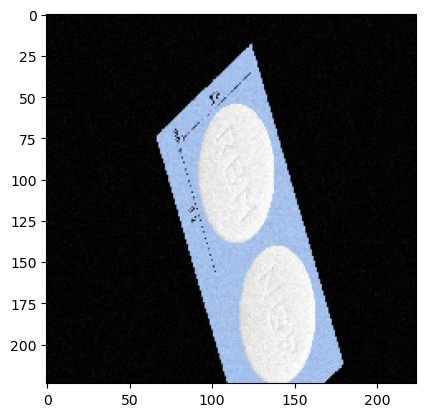

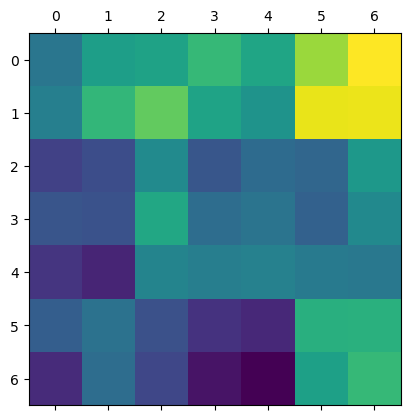

Predicted: 라베맥스정10밀리그램
정답:  경보라베프라졸정20mg


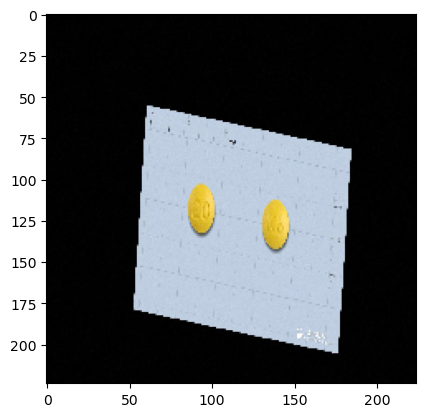

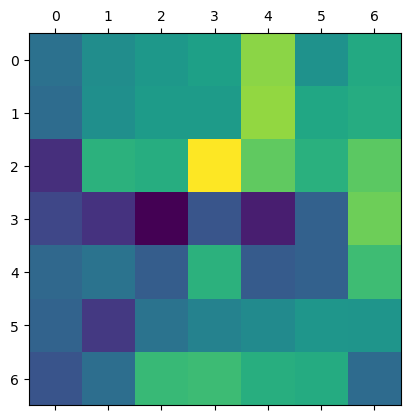

Predicted: 몬테레어츄정5밀리그램
정답:  레프리드정


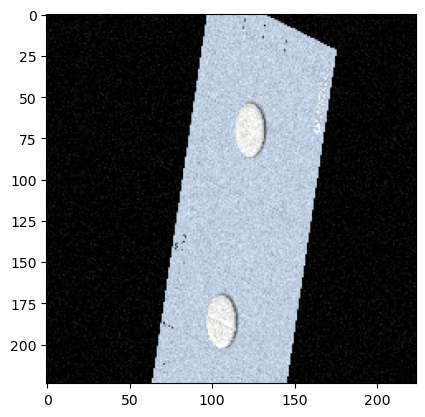

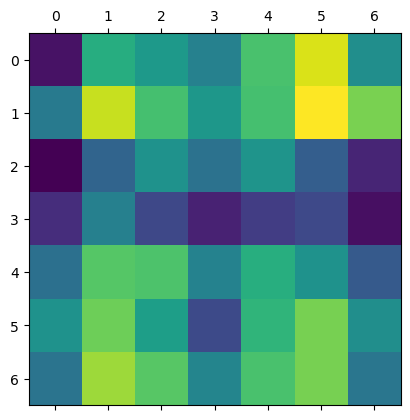

Predicted: 레록신정
정답:  덱사소론정0


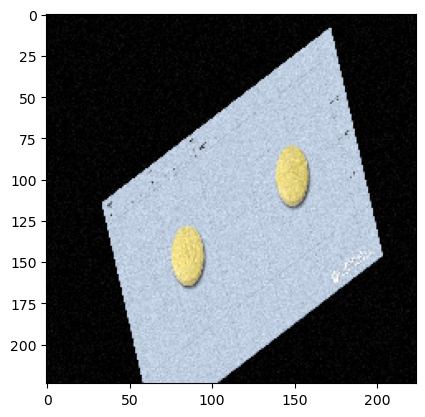

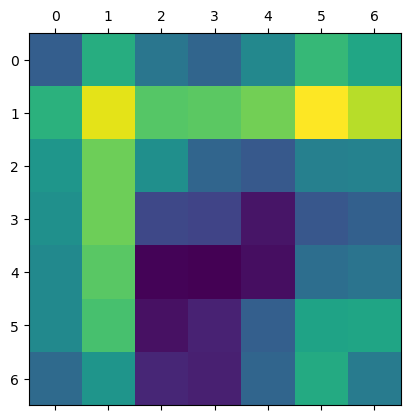

Predicted: 메이놀정
정답:  레바큐어정


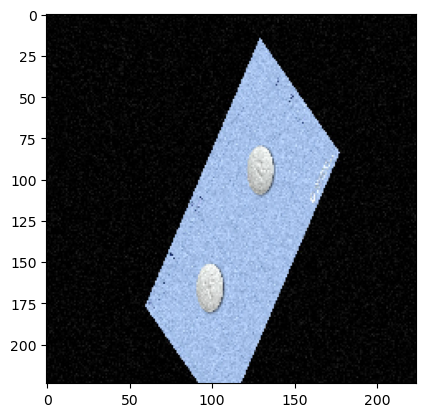

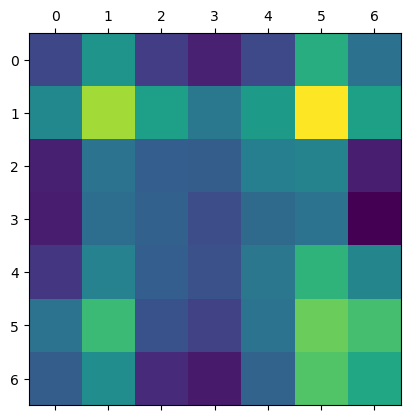

Predicted: 로도핀정25mg
정답:  로도핀정25mg


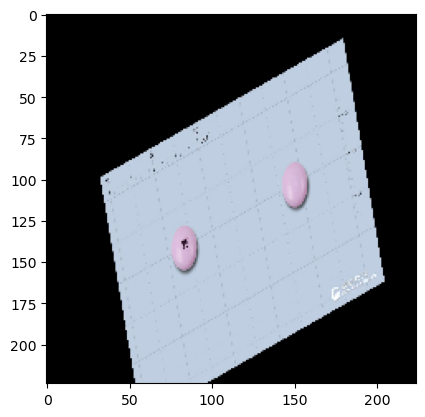

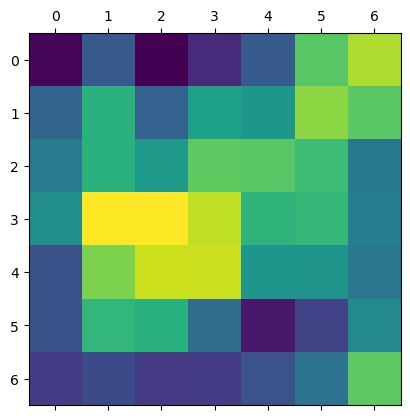

Predicted: 나노디오정600밀리그램
정답:  록소아펜정


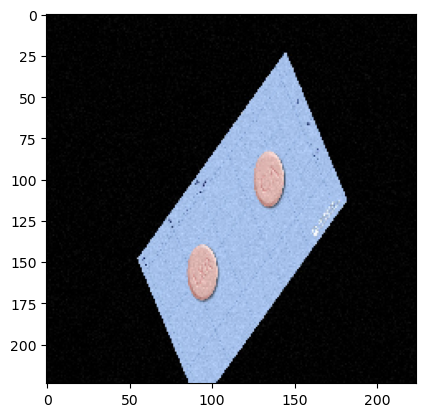

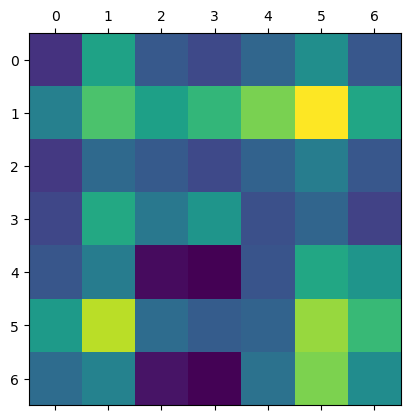

Predicted: 레바미론정
정답:  레바미론정


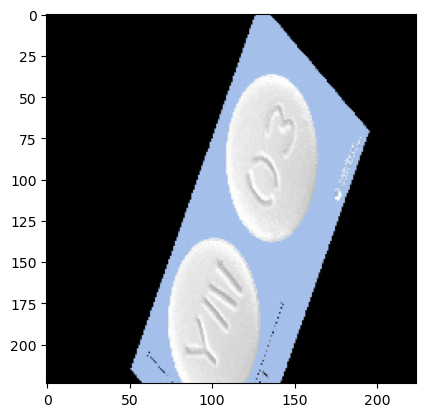

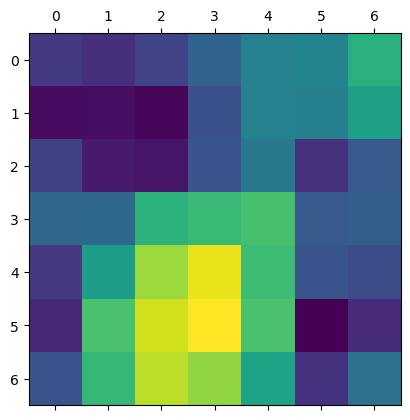

Predicted: 명도파정50
정답:  록시미드정150밀리그램


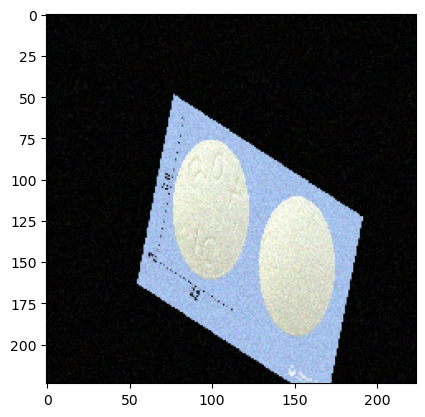

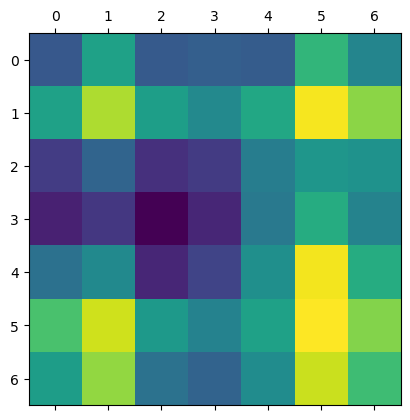

In [82]:
for i in range(10):
    inum = random.randrange(0,len(test_folders))
    qimage0 = load_img(os.path.join(test_folder_dir, test_folders[inum]), target_size=(224, 224))
    qimage  = img_to_array(qimage0)
    qimage  = qimage.reshape((1, 224, 224, 3))
    qimage  = preprocess_input(qimage)


    # Print what the top predicted class is
    preds = model.predict(qimage)
    predicted_label = np.argmax(preds,axis=-1)
    print("Predicted:", class_list[int(predicted_label)])
    print("정답: ", re.split('[/,(,). :, _]',test_folders[inum])[0])


    # Generate class activation heatmap
    last_conv_layer_name = "Conv_1"
    classifier_layer_names = [
        "global_average_pooling2d_1",
        "dense_2" 
        ]
    heatmap = make_gradcam_heatmap(
        qimage, model, last_conv_layer_name, classifier_layer_names
        )

    # Display heatmap
    plt.imshow(qimage0)
    plt.show()
    plt.matshow(heatmap)
    plt.show()